# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

#matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory data analysis

### Profile

In [2]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
profile.shape

(17000, 5)

In [4]:
profile['id'].nunique()

17000

In [5]:
# Percent missing vaues per column
profile.isnull().sum()/profile.shape[0]*100

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [6]:
sum(profile['gender'].isnull()) - sum(profile['gender'].isnull() & profile['income'].isnull())

0

Note that the missing values in the gender and income columns are in the same rows, most likely these are users who don't want to provide such information. 

In [7]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [8]:
# Convert 'became_member_on' to date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

In [9]:
profile['became_member_on'].min(), profile['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

In [10]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


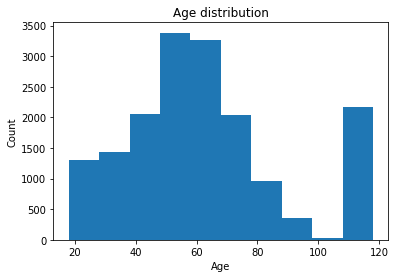

In [11]:
# Age
plt.hist(profile['age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.savefig('Age');

We see that there are a bunch of users (almost 13%!) aged 100+ which is highly inplausible. Most of them actually entered 118 (why?) as their age. Maybe replace by nans if we decide to use age for predictions. 

In [12]:
profile[profile['age'] > 100]['age'].value_counts()

118    2175
101       5
Name: age, dtype: int64

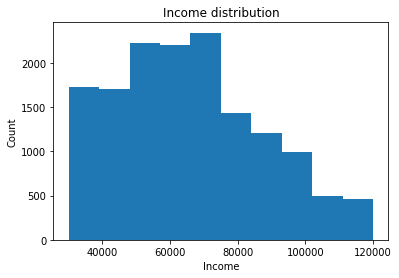

In [13]:
# Income
plt.hist(profile[~profile['income'].isnull()]['income'])
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income distribution')
plt.savefig('Income');

In [14]:
# Replace NaNs in the 'gender' and 'income' columns
profile['gender'].fillna('N/A', inplace=True)

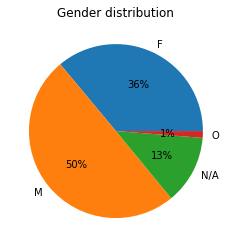

In [15]:
# Gender
profile.groupby('gender')['id'].count().plot(kind='pie', autopct='%1.0f%%')
plt.ylabel('')
plt.title('Gender distribution')
plt.savefig('Gender');

In [16]:
profile.loc[profile['gender'] == 'N/A', 'gender'] = 'not specified'

### Portfolio

In [17]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [18]:
portfolio.shape

(10, 6)

In [19]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [20]:
# Percent missing values per column
portfolio.isnull().sum()/portfolio.shape[0]*100

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [21]:
for col in ['offer_type', 'duration', 'difficulty', 'reward']:
    print('unique values in {}: '.format(col), portfolio[col].unique())

unique values in offer_type:  ['bogo' 'informational' 'discount']
unique values in duration:  [ 7  5  4 10  3]
unique values in difficulty:  [10  0  5 20  7]
unique values in reward:  [10  0  5  3  2]


In [22]:
portfolio['duration'].unique()

array([ 7,  5,  4, 10,  3])

In [23]:
portfolio['difficulty'].unique()

array([10,  0,  5, 20,  7])

In [24]:
# Difficulty/Reward ratio
portfolio['difficulty/reward'] = portfolio['difficulty']/portfolio['reward']

In [25]:
# Split 'social' into 4 separate columns
channel_list =['web', 'email', 'mobile', 'social']
for channel in channel_list:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

In [26]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,difficulty/reward,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4.0,1,1,0,0


### Transcript

In [27]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
transcript.shape

(306534, 4)

In [29]:
# Percent missing values per column
transcript.isnull().sum()/transcript.shape[0]*100

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [30]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [31]:
# Unpack 'value'
value_unpacked = transcript['value'].apply(pd.Series)
value_unpacked.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [32]:
value_unpacked[(~value_unpacked['offer id'].isnull()) & (~value_unpacked['offer_id'].isnull())]

,offer id,amount,offer_id,reward


In [33]:
# Combine 'offer id' and 'offer_id'
value_unpacked['offer_id'].update(value_unpacked.pop('offer id'))

In [34]:
value_unpacked.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [35]:
value_unpacked.shape

(306534, 3)

In [36]:
# Merge with the original dataframe
transcript = pd.concat([transcript.drop('value', axis=1), value_unpacked], axis=1)

In [37]:
transcript.shape

(306534, 6)

In [38]:
transcript.head(5)

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [39]:
transcript_wide = pd.pivot_table(transcript, index=['person', 'offer_id'], columns='event', values='time').reset_index().rename_axis(None, axis=1)

In [40]:
transcript_wide.shape

(63288, 5)

In [41]:
transcript_wide.head()

,person,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0


In [42]:
col_list = list(transcript_wide.columns)
col_list

['person', 'offer_id', 'offer completed', 'offer received', 'offer viewed']

In [43]:
col_list[2], col_list[3], col_list[4] = col_list[3], col_list[4], col_list[2]

In [44]:
col_list

['person', 'offer_id', 'offer received', 'offer viewed', 'offer completed']

In [45]:
transcript_wide = transcript_wide[col_list]

In [46]:
transcript_wide.head()

,person,offer_id,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0


Note that now the values in the 'offer received', 'offer viewed', and 'offer completed' indicate time since start of test (in hours). 

In [47]:
transcript_wide['person'].nunique(), transcript['person'].nunique()

(16994, 17000)

There are 6 users who were present in *transript* table but not in the *transcript_wide* table. These should be only users who never receveid any offer. Let's verify that.

In [48]:
missing_persons = transcript[~transcript['person'].isin(transcript_wide['person'])]['person'].unique()
missing_persons

array(['eb540099db834cf59001f83a4561aef3',
       '12ede229379747bd8d74ccdc20097ca3',
       'c6e579c6821c41d1a7a6a9cf936e91bb',
       'ae8111e7e8cd4b60a8d35c42c1110555',
       '3a4874d8f0ef42b9a1b72294902afea9',
       'da7a7c0dcfcb41a8acc7864a53cf60fb'], dtype=object)

In [49]:
missing_df = transcript[transcript['person'].isin(missing_persons)]
missing_df

,person,event,time,amount,offer_id,reward
16379,eb540099db834cf59001f83a4561aef3,transaction,6,4.74,NaN,NaN
22092,12ede229379747bd8d74ccdc20097ca3,transaction,18,16.62,NaN,NaN
69477,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,174,0.65,NaN,NaN
87239,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,222,1.91,NaN,NaN
106812,ae8111e7e8cd4b60a8d35c42c1110555,transaction,306,17.51,NaN,NaN
108268,eb540099db834cf59001f83a4561aef3,transaction,318,5.09,NaN,NaN
109340,3a4874d8f0ef42b9a1b72294902afea9,transaction,324,22.75,NaN,NaN
109815,12ede229379747bd8d74ccdc20097ca3,transaction,324,27.60,NaN,NaN
110707,ae8111e7e8cd4b60a8d35c42c1110555,transaction,330,28.70,NaN,NaN
142347,3a4874d8f0ef42b9a1b72294902afea9,transaction,378,27.20,NaN,NaN


In [50]:
transcript_wide.head()

,person,offer_id,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0


#### Average time to view and complete an offer

In [51]:
print('Average time to see an offer is {} hours after receiving it.'.format(np.ceil((transcript_wide['offer viewed'] - transcript_wide['offer received']).mean())))
print('Average time to complete an offer is {} hours after receiving it.'.format(np.ceil((transcript_wide['offer completed'] - transcript_wide['offer received']).mean())))

Average time to see an offer is 27.0 hours after receiving it.
Average time to complete an offer is 65.0 hours after receiving it.


#### How many offers were sent, viewed, and completed?

In [52]:
transcript_wide[['offer received', 'offer viewed', 'offer completed']].count(axis=0)

offer received     63288
offer viewed       49135
offer completed    28996
dtype: int64

#### How many offers were completed without being viewed?

#### What is the most popular type of offer that gets sent, viewed, completed?

In [53]:
# Merge with portfolio
transcript_wide_portfolio = transcript_wide.merge(portfolio, how='left', left_on='offer_id', right_on='id').drop('id', axis=1)

In [54]:
transcript_wide_portfolio.head()

,person,offer_id,offer received,offer viewed,offer completed,reward,channels,difficulty,duration,offer_type,difficulty/reward,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,2,"[web, email, mobile]",10,7,discount,5.0,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,0,"[web, email, mobile]",0,4,informational,NaN,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,0,"[email, mobile, social]",0,3,informational,NaN,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,5,"[web, email, mobile, social]",5,5,bogo,1.0,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,2,"[web, email, mobile, social]",10,10,discount,5.0,1,1,1,1


Text(0.5, 1.0, 'Duration')

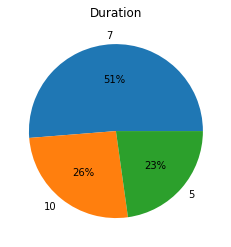

In [55]:
# Completed offers by duration
transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0]['duration'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.ylabel('')
plt.title('Duration')

Text(0.5, 1.0, 'Difficulty')

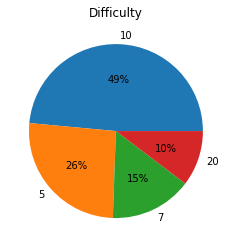

In [56]:
# Completed offers by difficulty
transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0]['difficulty'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.ylabel('')
plt.title('Difficulty')

Text(0.5, 1.0, 'Reward')

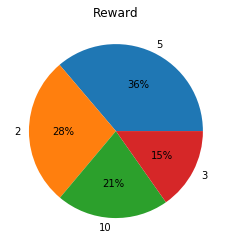

In [57]:
# Completed offers by reward
transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0]['reward'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.ylabel('')
plt.title('Reward')

In [58]:
(round(transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0].groupby(['offer_type', 'difficulty', 'duration', 'reward']) \
    ['offer completed'].count()*100/transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0].shape[0], 2)).reset_index().sort_values(by='offer completed', ascending=False) \
   

,offer_type,difficulty,duration,reward,offer completed
6,discount,10,10,2,15.64
4,discount,7,7,3,15.25
1,bogo,5,7,5,13.03
0,bogo,5,5,5,12.88
5,discount,10,7,2,12.02
3,bogo,10,7,10,10.96
7,discount,20,10,5,10.31
2,bogo,10,5,10,9.91


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


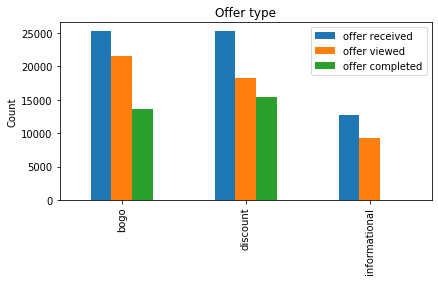

In [59]:
transcript_wide_portfolio.groupby('offer_type')['offer received', 'offer viewed', 'offer completed'].count() \
    .plot.bar()
plt.tight_layout()
plt.xlabel('')
plt.ylabel('Count')
plt.title('Offer type')
plt.savefig('Offer type', bbox_inches='tight');

In [60]:
transcript_wide_portfolio.groupby('offer_type')['offer received', 'offer viewed', 'offer completed'] \
    .apply(lambda x: x.count()/x.shape[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,offer received,offer viewed,offer completed
offer_type,,,
bogo,1.0,0.850914,0.536590
discount,1.0,0.722073,0.608666
informational,1.0,0.735831,0.000000


We see that even though the BOGO offers get viewed most frequently, only about 54% of them get completed. On the other hand, the discount offers get viewed only 72% (the lowest % from the three types) of the time but get completed almost 61% of the time. 

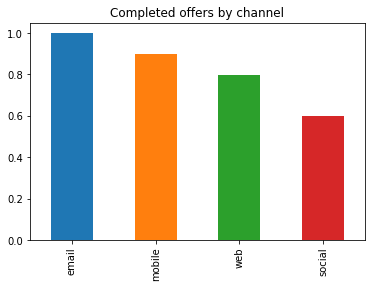

In [61]:
# Completed offers by channel
transcript_wide_portfolio[['web', 'email', 'mobile', 'social']].mean() \
    .sort_values(ascending=False).plot.bar(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Completed offers by channel');

In [62]:
transcript_wide_portfolio[['web', 'email', 'mobile', 'social']].mean()

web       0.799425
email     1.000000
mobile    0.899286
social    0.599529
dtype: float64

Reminder: the values in the 'offer received', 'offer viewed', and 'offer completed' indicate time since start of test (in hours). Since we are interested in whether an offer gets completed or not, we will add a new boolean column 'offer_viewed_yes_no'.

In [63]:
# Create 'offer_viewed_yes_no' indicating whether an offer is completed or not
transcript_wide_portfolio['offer_completed_yes_no'] = transcript_wide_portfolio['offer completed'].apply(lambda x: 1 if x > 0 else 0)
transcript_wide_portfolio['offer_viewed_yes_no'] = transcript_wide_portfolio['offer viewed'].apply(lambda x: 1 if x > 0 else 0)

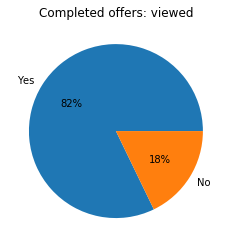

In [64]:
fig1, ax1 = plt.subplots()
new_labels = ['Yes', 'No']
transcript_wide_portfolio[transcript_wide_portfolio['offer completed']>0]['offer_viewed_yes_no'].value_counts() \
    .plot(kind='pie', autopct='%1.0f%%', labels=new_labels)
plt.ylabel('')
plt.title('Completed offers: viewed')
plt.savefig('Completed offers: viewed');

# Modeling

### Data preparation

We are going to try to predict which users are more responsive to offers. We want to build a model where the target variable is 'offer completed' and predictors are some of the following: user's age, gender, income, offer's type, duration, difficulty, reward, difficulty/duration ratio, channel.

In [65]:
# Merge transcript_wide_portfolio with profiles to get the demographic data
df_all = transcript_wide_portfolio.merge(profile, how='left', left_on='person', right_on='id').drop(['id', 'became_member_on'], axis=1)

In [66]:
df_all.shape

(63288, 20)

In [67]:
df_all.head()

,person,offer_id,offer received,offer viewed,offer completed,reward,channels,difficulty,duration,offer_type,difficulty/reward,web,email,mobile,social,offer_completed_yes_no,offer_viewed_yes_no,gender,age,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,2,"[web, email, mobile]",10,7,discount,5.0,1,1,1,0,1,0,M,33,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,0,"[web, email, mobile]",0,4,informational,NaN,1,1,1,0,0,1,M,33,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,0,"[email, mobile, social]",0,3,informational,NaN,0,1,1,1,0,1,M,33,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,5,"[web, email, mobile, social]",5,5,bogo,1.0,1,1,1,1,1,1,M,33,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,2,"[web, email, mobile, social]",10,10,discount,5.0,1,1,1,1,1,1,M,33,72000.0


In [68]:
# drop informational offers since they cannot be completed
df_all = df_all[df_all['offer_type']!='informational']
df_all.shape

(50637, 20)

In [69]:
df_all.isnull().sum()/df_all.shape[0]

person                    0.000000
offer_id                  0.000000
offer received            0.000000
offer viewed              0.213500
offer completed           0.427375
reward                    0.000000
channels                  0.000000
difficulty                0.000000
duration                  0.000000
offer_type                0.000000
difficulty/reward         0.000000
web                       0.000000
email                     0.000000
mobile                    0.000000
social                    0.000000
offer_completed_yes_no    0.000000
offer_viewed_yes_no       0.000000
gender                    0.000000
age                       0.000000
income                    0.127496
dtype: float64

In [70]:
# Bucket 'income'
df_all.loc[df_all['income']<49000, 'income_buckets'] = 'low'
df_all.loc[(df_all['income']>=49000) & (df_all['income']<64000), 'income_buckets'] = 'low/middle'
df_all.loc[(df_all['income']>=64000) & (df_all['income']<80000), 'income_buckets'] = 'middle/high'
# df_all.loc[(df_all['income']>=85000) & (df_all['income']<100000), 'income_buckets'] = 'middle/high'
df_all.loc[df_all['income']>=80000, 'income_buckets'] = 'high'
df_all.loc[df_all['income'].isnull(), 'income_buckets'] = 'not_specified'

As noticed before, almost 13% of the values in the 'age' column are 118 which seesm highly inplausible. Most likely these users didn't want to enter their actual age and just selected the first possible. We will replace these values with 'not specified'.

In [71]:
# Replace age 118 with 'not specified' and bucket the variable
df_all.loc[df_all['age']==118, 'age_buckets'] = 'not_specified'
df_all.loc[df_all['age']<20, 'age_buckets'] = '<20'
df_all.loc[(df_all['age']>=20) & (df_all['age']<30), 'age_buckets'] = '20s'
df_all.loc[(df_all['age']>=30) & (df_all['age']<40), 'age_buckets'] = '30s'
df_all.loc[(df_all['age']>=40) & (df_all['age']<50), 'age_buckets'] = '40s'
df_all.loc[(df_all['age']>=50) & (df_all['age']<60), 'age_buckets'] = '50s'
df_all.loc[df_all['age']>=60, 'age_buckets'] = '60+'

In [72]:
df_all.head()

,person,offer_id,offer received,offer viewed,offer completed,reward,channels,difficulty,duration,offer_type,...,email,mobile,social,offer_completed_yes_no,offer_viewed_yes_no,gender,age,income,income_buckets,age_buckets
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,2,"[web, email, mobile]",10,7,discount,...,1,1,0,1,0,M,33,72000.0,middle/high,30s
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,5,"[web, email, mobile, social]",5,5,bogo,...,1,1,1,1,1,M,33,72000.0,middle/high,30s
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,2,"[web, email, mobile, social]",10,10,discount,...,1,1,1,1,1,M,33,72000.0,middle/high,30s
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,372.0,423.0,NaN,5,"[web, email, mobile, social]",5,5,bogo,...,1,1,1,0,1,not specified,118,NaN,not_specified,60+
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,5,"[web, email]",20,10,discount,...,1,0,0,1,1,O,40,57000.0,low/middle,40s


Reminder: the values in the 'offer received', 'offer viewed', and 'offer completed' indicate time since start of test (in hours). Since we are interested in whether an offer gets completed or not, as above, we will add a new boolean column 'offer_completed_yes_no'.

In [73]:
# Create 'offer_completed_yes_no' indicating whether an offer is completed or not
df_all['offer_completed_yes_no'] = df_all['offer completed'].apply(lambda x: 1 if x > 0 else 0)

In [74]:
# Convert 'duration' and 'difficulty' to categorical
# df_all.loc[:,'duration'] = df_all.loc[:, 'duration'].astype(str)
# df_all.loc[:,'difficulty'] = df_all.loc[:, 'difficulty'].astype(str)

In [75]:
# # DO NOT TOUCH
# pred = ['difficulty', 'duration', 'offer_type', 'reward', 'age', 'gender', 'income_buckets', \
#         'web', 'email', 'mobile', 'social', 'offer_viewed_yes_no']

In [76]:
pred = ['difficulty', 'duration', 'offer_type', 'reward', 'gender', 'income_buckets', \
        'web', 'email', 'mobile', 'social', 'offer_viewed_yes_no', 'age_buckets']

In [77]:
X, y = df_all[pred], df_all['offer_completed_yes_no']
X.head()

,difficulty,duration,offer_type,reward,gender,income_buckets,web,email,mobile,social,offer_viewed_yes_no,age_buckets
0,10,7,discount,2,M,middle/high,1,1,1,0,0,30s
3,5,5,bogo,5,M,middle/high,1,1,1,1,1,30s
4,10,10,discount,2,M,middle/high,1,1,1,1,1,30s
5,5,5,bogo,5,not specified,not_specified,1,1,1,1,1,60+
6,20,10,discount,5,O,low/middle,1,1,0,0,1,40s


We are going to use **sklearn** for modeling and thus we have to convert all categorical variables to numeric.

In [78]:
# Dummify categorical variables
var_dummy = pd.get_dummies(X[['gender', 'offer_type', 'income_buckets', 'age_buckets']])

In [79]:
# Concatenate with X and drop original 'offer type' and 'gender' columns
X_dummy = pd.concat([X, var_dummy], axis=1).drop(['offer_type', 'gender', 'income_buckets', 'age_buckets'], axis=1)
X_dummy.head()

,difficulty,duration,reward,web,email,mobile,social,offer_viewed_yes_no,gender_F,gender_M,...,income_buckets_low,income_buckets_low/middle,income_buckets_middle/high,income_buckets_not_specified,age_buckets_20s,age_buckets_30s,age_buckets_40s,age_buckets_50s,age_buckets_60+,age_buckets_<20
0,10,7,2,1,1,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3,5,5,5,1,1,1,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0
4,10,10,2,1,1,1,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0
5,5,5,5,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
6,20,10,5,1,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


### Model training and prediction

In [80]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3,random_state = 7)

In [81]:
X_train.dtypes

difficulty                      int64
duration                        int64
reward                          int64
web                             int64
email                           int64
mobile                          int64
social                          int64
offer_viewed_yes_no             int64
gender_F                        uint8
gender_M                        uint8
gender_O                        uint8
gender_not specified            uint8
offer_type_bogo                 uint8
offer_type_discount             uint8
income_buckets_high             uint8
income_buckets_low              uint8
income_buckets_low/middle       uint8
income_buckets_middle/high      uint8
income_buckets_not_specified    uint8
age_buckets_20s                 uint8
age_buckets_30s                 uint8
age_buckets_40s                 uint8
age_buckets_50s                 uint8
age_buckets_60+                 uint8
age_buckets_<20                 uint8
dtype: object

#### Model 1: Logistic Regression

In [82]:
# Initiate logistic regression classifier
lr = LogisticRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
# Predict 
y_pred = lr.predict(X_test)

# Check accuracy of the model
accuracy_score(y_test, y_pred)

0.7232095839915745

In [84]:
lr_coeff = pd.DataFrame({'feature_name': X_train.columns, 'model_coefficient': lr.coef_.transpose().flatten()})
lr_coeff = lr_coeff.sort_values('model_coefficient',ascending=False)

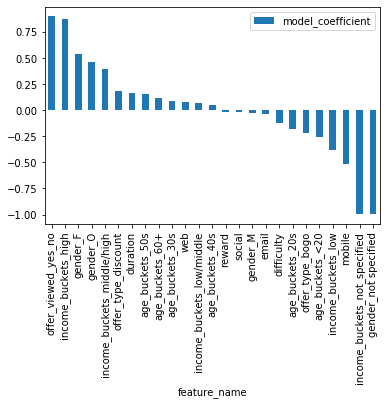

In [85]:
lr_coeff.set_index(lr_coeff['feature_name'], inplace=True)
lr_coeff.plot(kind='bar');

#### Model 2: Random Forest

In [86]:
# Initiate random forest classifier
rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
# Predict 
y_pred = rf.predict(X_test)

# Check accuracy of the model
accuracy_score(y_test, y_pred)

0.7230121116377041

#### Model 3: AdaBoost

In [88]:
# Initiate boosted decision tree classifier
ada = AdaBoostClassifier(DecisionTreeClassifier())

# Fit the model on the training data
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [89]:
# Predict 
y_pred = ada.predict(X_test)

# Check accuracy of the model
accuracy_score(y_test, y_pred)

0.7222880463401791

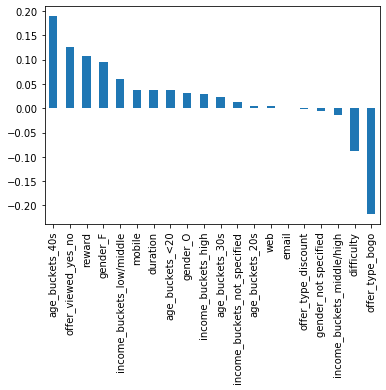

In [90]:
important_features = pd.Series(data=ada.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False).head(20).plot(kind='bar');

Try to improve the accuracy by tuning the parameters.

In [91]:
ada.get_params() 

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
               

In [100]:
param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
              'base_estimator__splitter' :   ['best', 'random'],
              'base_estimator__max_depth': [None, 2, 5, 10],
              'base_estimator__min_samples_split': [10, 20, 50],
              'n_estimators': [50, 100],
              'random_state': [7]
             }

In [101]:
grid = GridSearchCV(ada, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [102]:
best_estimator = grid.best_estimator_
best_estimator

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=10,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [103]:
# Predict 
y_pred = best_estimator.predict(X_test)

# Check accuracy of the model
accuracy_score(y_test, y_pred)

0.7247893628225381

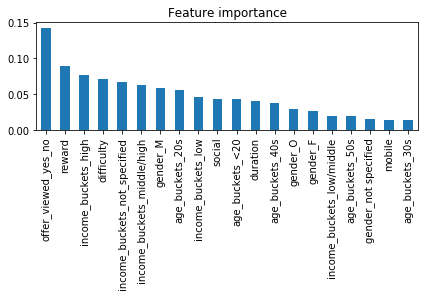

In [116]:
important_features = pd.Series(data=grid.best_estimator_.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False).head(20).plot(kind='bar')
plt.tight_layout()
plt.title('Feature importance')
plt.savefig('Feature importance',  bbox_inches='tight');